# 10. Final models on the merged cohort
1. **final 4-fold CV on the merged cohort**
    - 3P/3P+LSM/LSM logistic regression models
    - needs to be done on the same set of patients, i.e. those who have all these 4 measurements
2. **report performance of 3P + LSM model on different etiologies**
    - train on merged cohort
3. **report predictions for 3P(+LSM) model and extract coefficient sets**
    - both logistic regression (probabilities) and normal regression (predicted HVPG)
    
- Corresponds to Figure 4 in the manuscript
    
<sub>original notebook name: `VICIS_20_final_model_ETIO_performance.ipynb`</sub>

### Load merged cohort, keep only patients with 3P + LSM measurements present

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# prediction models
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

# plotting configuration
from matplotlib import rc_params
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 16

from HVPG16_functions import *

In [2]:
preprocessed_data_path = "/Users/jreinis/OneDrive/Rotation/rotation/data_collaborators_updated_v3/merged_datasets_HVPG_strictly_compensated_center_names.csv"
data_with_predictions_output_folder = "/Users/jreinis/Documents/OneDrive - CeMM Research Center GmbH/Rotation/rotation/data_with_predictions/"
output_folder_plots = "/Users/jreinis/Documents/OneDrive - CeMM Research Center GmbH/Rotation/rotation/HVPG16_manuscript_figures/"

In [3]:
data = pd.read_csv(preprocessed_data_path)
# call liver stiffness just LSM
data.rename(columns = {"VCTE-LSM-kPa":"LSM"}, inplace=True)
data["HVPG_label"] = "HVPG < 16"
data.loc[data.HVPG >= 16, 'HVPG_label'] = "HVPG ≥ 16"

### Final 4-fold CV on the merged cohort
- 3P+LSM vs 3P vs LSM 

In [4]:
# remove patients with incomplete records for the required parameters
data_subset = data.copy()
for variable in ["HVPG"] + ["PLT", "BILI", "aPTT", "LSM"]:
    data_subset = data_subset[data_subset[variable].notnull()]
data_subset = data_subset.reset_index(drop=True)
data_subset.shape[0]

513

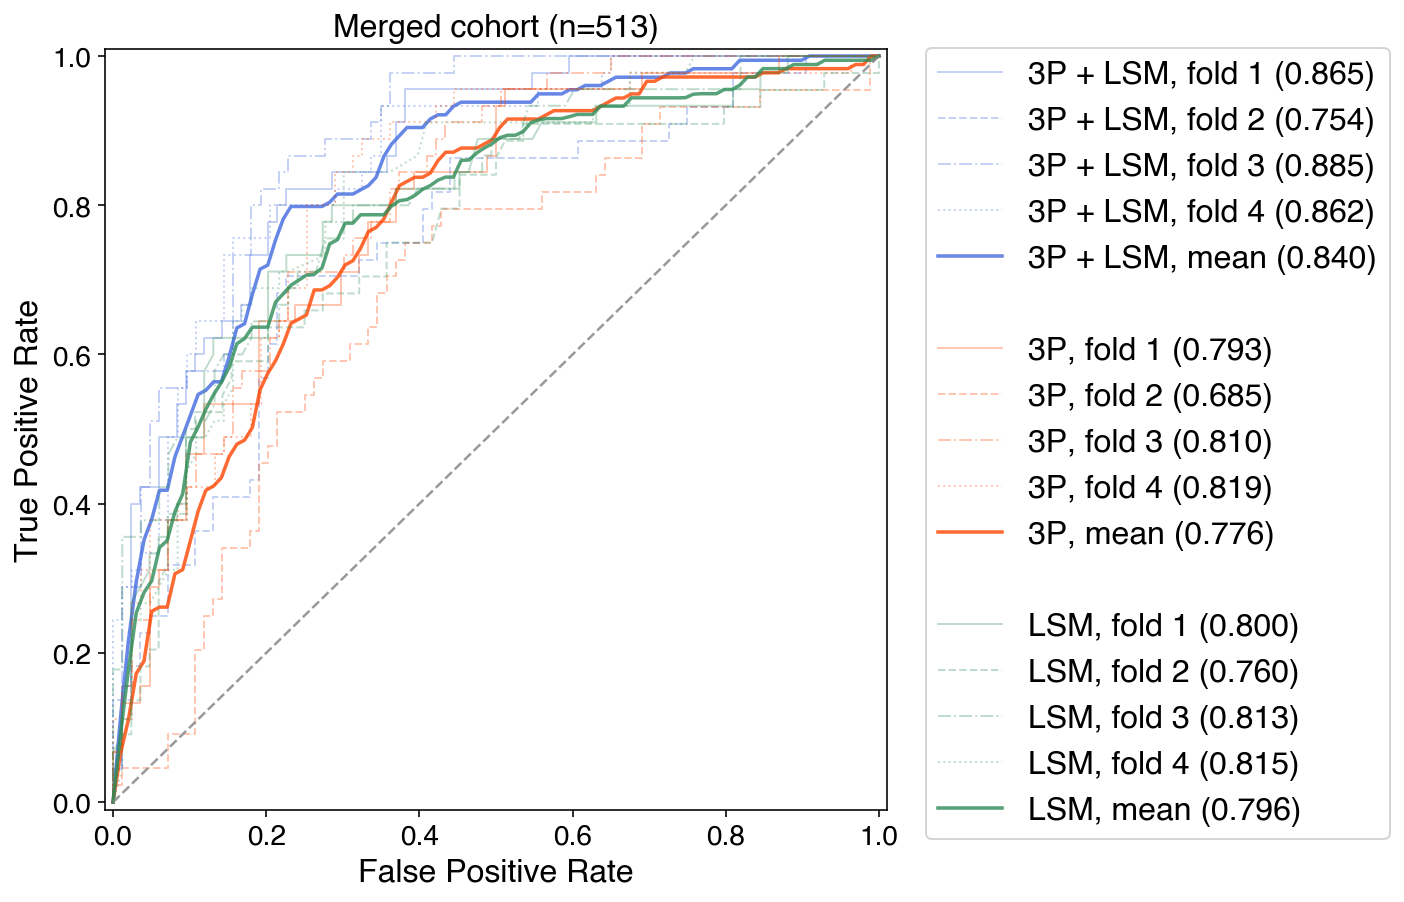

In [5]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=4422)
classifier = LogisticRegression(C=0.6, warm_start=False, max_iter=1000)

ax = plt.figure(figsize=(7,7))

X = data_subset[["PLT", "BILI", "aPTT", "LSM"]]
y = 1*(data_subset["HVPG"] >= 16)
plot_ROC_CV(classifier, cv, X, y, "royalblue", "3P + LSM")

# trick to have space in the legend
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='white', label=' ', alpha=.8)

X = data_subset[["PLT", "BILI", "aPTT"]]
y = 1*(data_subset["HVPG"] >= 16)
plot_ROC_CV(classifier, cv, X, y, "orangered", "3P")

# trick to have space in the legend
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='white', label=' ', alpha=.8)

X = data_subset[["LSM"]]
y = 1*(data_subset["HVPG"] >= 16)
plot_ROC_CV(classifier, cv, X, y, "seagreen", "LSM")

plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='grey', label='', alpha=.8)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1.001), loc=2, borderaxespad=0.,prop={"size":16})
plt.title(f"Merged cohort (n={len(data_subset)})", fontsize=16)
plt.savefig(output_folder_plots + "merged_cohort_final_CV_comparison.pdf", bbox_inches="tight")
plt.show()

### Prediction performance for different etiologies

In [6]:
X = data_subset[["PLT", "BILI", "aPTT", "LSM"]]
y = 1*(data_subset["HVPG"] >= 16)
lr = LogisticRegression(C=0.6, warm_start=False, max_iter=1000).fit(X, y)

In [7]:
etiology_codes = {1:"ALD",
                  2:"VIRAL",
                  3:"ALD+VIRAL",
                  4:"NASH",
                  5:"CHOL",
                  6:"OTHER"}

In [8]:
data_etio = [data_subset[data_subset["Etiology"] == str(etio)] for etio in etiology_codes.keys()]

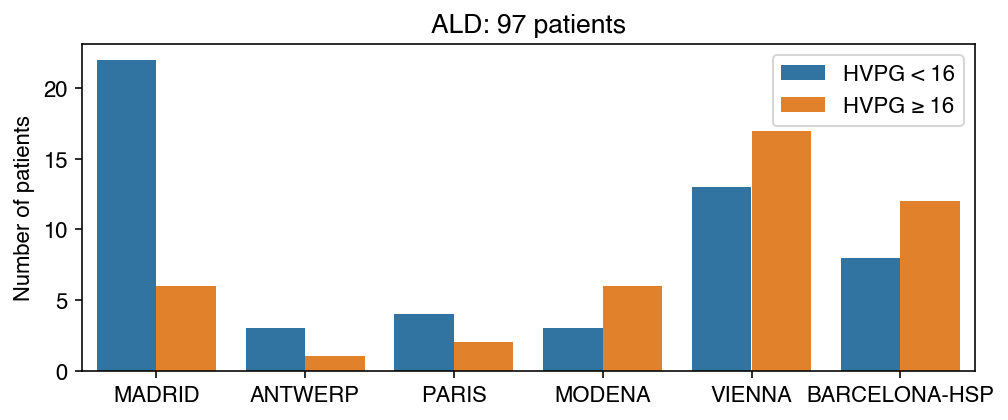

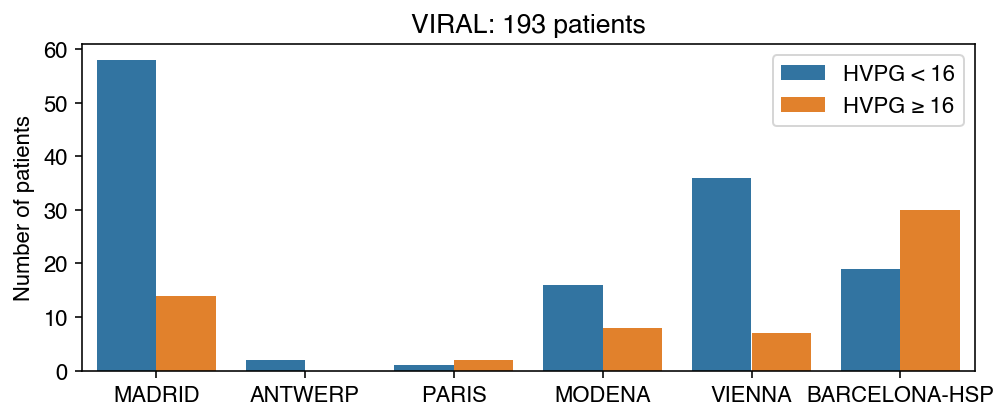

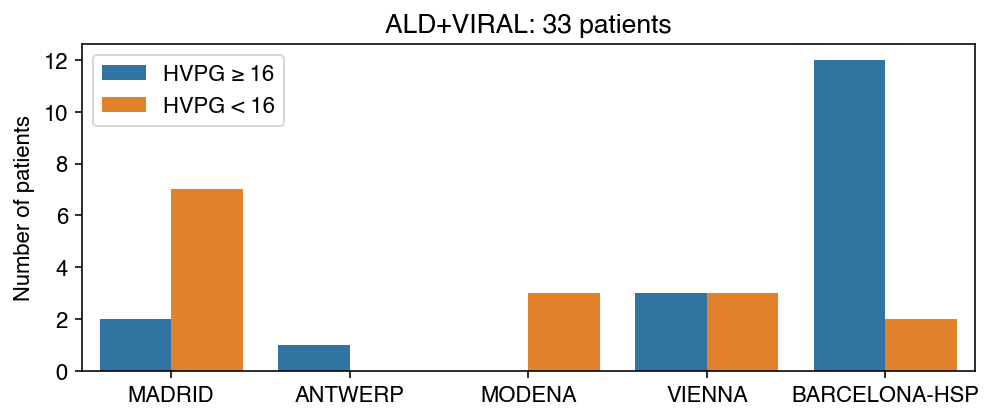

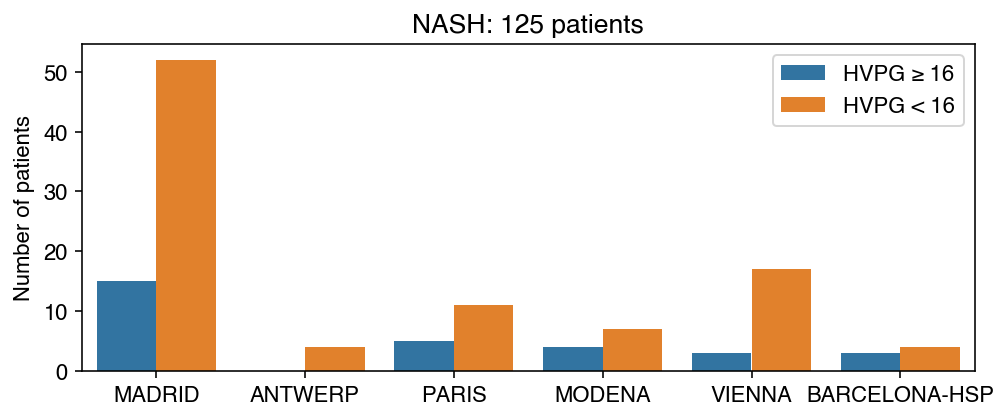

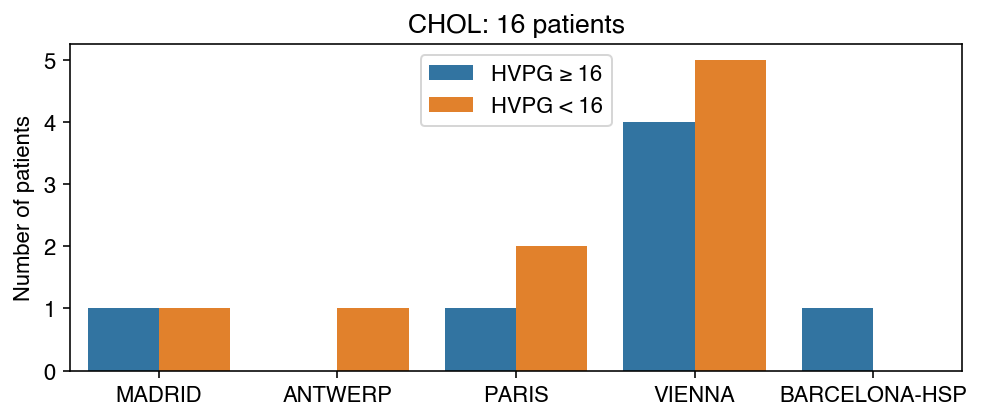

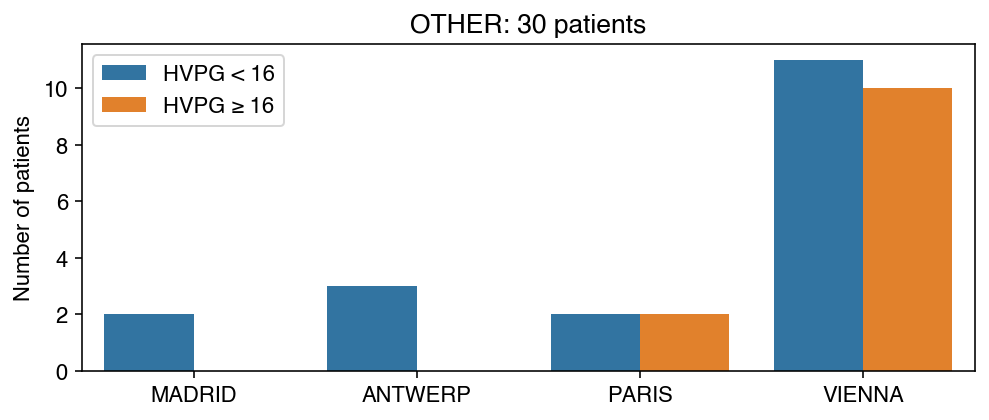

In [9]:
total = np.array([etio.shape[0] for etio in data_etio])
high_risk = np.array([etio.HVPG_label.value_counts()[1] for etio in data_etio])
high_risk_fraction = [f"{x*100:.1f}" for x in (high_risk/total)]
AUCs = []

for i, etio in enumerate(data_etio):
    etio_name = etiology_codes[i+1]
    plt.figure(figsize=(8,3))
    ax = sns.countplot(x = 'dataset', data = etio, hue = "HVPG_label")
    ax.set_title(f'{etio_name}: {etio.shape[0]} patients')
    handles, labels = ax.get_legend_handles_labels(); ax.legend(handles=handles[:], labels=labels[:])
    plt.xlabel("")
    plt.ylabel("Number of patients")
    plt.savefig(f'{output_folder_plots}HVPG_distribution_etiologies_split/{etio_name.replace("+","_")}.pdf', bbox_inches="tight")
    plt.show()
    
    AUC = roc_auc_score(1*(etio["HVPG"] >= 16), lr.predict_proba(etio[["PLT", "BILI", "aPTT", "LSM"]])[:, 1])
    AUC = f"{AUC:.03f}"
    AUCs.append(AUC)
    print()

In [10]:
pd.DataFrame({"Etiology":etiology_codes.values(), "AUC":AUCs, "Total patients":total, "HVPG>=16":high_risk, "HVPG>=16 (%)":high_risk_fraction,})

,Etiology,AUC,Total patients,HVPG>=16,HVPG>=16 (%)
0,ALD,0.862,97,44,45.4
1,VIRAL,0.794,193,61,31.6
2,ALD+VIRAL,0.870,33,15,45.5
3,NASH,0.906,125,30,24.0
4,CHOL,0.937,16,7,43.8
5,OTHER,0.833,30,12,40.0


### Train final models on merged cohort
- for each parameter set, train on the complete cohort of patients with records present
- train a logistic regression (classification) and lasso regression (regression) models

In [11]:
def plot_ROC_v2(clf, X, y, ax, color='r', model=""):
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='grey', label='', alpha=.8)
    
    # get points on ROC curve
    probas_ = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    # calculate optimal threshold (Youden's index)
    idx = np.argmax(tpr - fpr)
    
    # plot
    ax.plot(fpr, tpr, lw=1.5, alpha=0.8, color=color, label=f'{model} ({roc_auc:.3f})')
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.set_title(f"{model} (n={len(X)}, AUC={roc_auc:.3f})",fontsize=16)
    return roc_auc, thresholds[idx]

In [12]:
def plot_regression_v2(reg, X, y,  ax, model=""):
    y_pred = reg.predict(X)
    r2 = r2_score(y, y_pred)
    # scatterplot of y
    sns.scatterplot(x = y, y = y_pred, ax=ax)
    ax.axhline(16, ls = "--", color = "r", lw = .75) 
    ax.axvline(16, ls = "--", color = "r", lw = .75)
    ax.axis('equal')
    ax.axline((5, 5), (6, 6), ls = "-", color = "black", lw = .75, alpha = .3)
    ax.set_xlabel('HVPG',fontsize=16)
    ax.set_ylabel('Predicted HVPG',fontsize=16)
    ax.set_title(f"{model} (n={len(X)}, $r^2$={r2:.3f})",fontsize=16)
    return r2

In [13]:
def train_final_model(data, parameters, name):
    df = data[["HVPG"] + parameters].dropna(axis=0)
    
    # prepare data for training
    X = df[parameters]
    y_clf = 1*(df["HVPG"]>=16)
    y_reg = df["HVPG"]

    # train models
    lr = LogisticRegression(C = 1, max_iter=15000).fit(X, y_clf)
    reg = Ridge(alpha=50).fit(X, y_reg)
    
    # plot ROC curve and regression evaluation thingy
    f, (ax1, ax2) = plt.subplots(1, 2)
    auc, best_threshold = plot_ROC_v2(lr, X, y_clf, ax1, model=name)
    r2 = plot_regression_v2(reg, X, y_reg, ax2, model=name)
    plt.show()
    
    # general info
    print(f'[{", ".join(parameters)}]: {df.shape[0]} patients\n')
    
    # metrics and coefficients - classification
    print(f"AUROC (train and validate on same data): {roc_auc_score(y_clf, lr.predict_proba(X)[:, 1]):.3f}")
    print(f'Logistic regression coefficients: intercept={lr.intercept_[0]:.6f}, {", ".join([f"{par}={weight:.6f}" for par,weight in list(zip(parameters,lr.coef_[0]))])}')
    print(f"Optimal threshold: {best_threshold:.3f}\n")

    
    # metrics and coefficients - classification
    print(f"r2 score (train and validate on same data): {r2_score(y_reg, reg.predict(X)):.3f}")
    print(f'Regression coefficients: intercept={reg.intercept_:.6f}, {", ".join([f"{par}={weight:.6f}" for par,weight in list(zip(parameters,reg.coef_))])}')
    
    return lr, auc, reg, r2, best_threshold

In [14]:
names = ['5P', '3P', '5P + LSM', '3P + LSM', 'LSM-only']
variables = [['PLT', 'BILI', 'aPTT', 'CHE', 'GGT'],
             ['PLT', 'BILI', 'aPTT'],
             ['PLT', 'BILI', 'aPTT', 'CHE', 'GGT', 'LSM'],
             ['PLT', 'BILI', 'aPTT', 'LSM'],
             ['LSM']]

In [15]:
n_patients = [data[["HVPG"] + pars].dropna(axis=0).shape[0] for pars in variables]
lrs, aucs, regs, r2s, best_thresholds = [],[],[],[],[]

#### 5-parameter

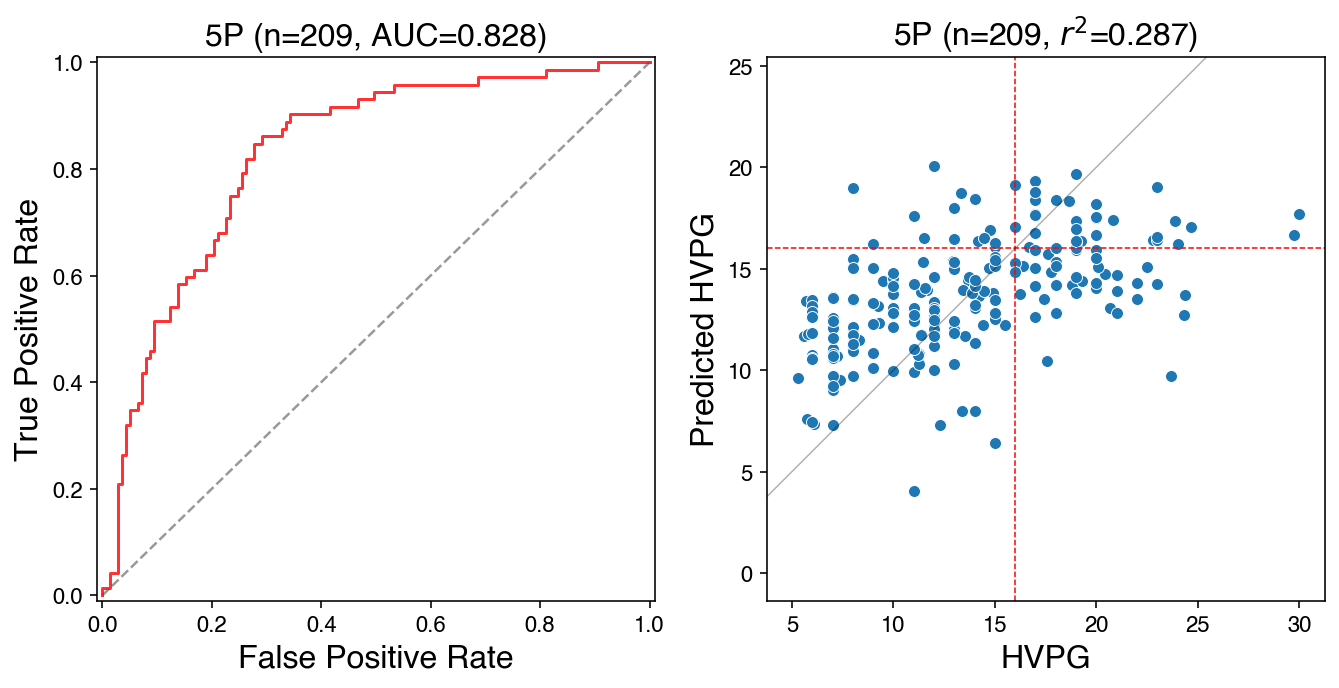

[PLT, BILI, aPTT, CHE, GGT]: 209 patients

AUROC (train and validate on same data): 0.828
Logistic regression coefficients: intercept=-2.245109, PLT=-0.018408, BILI=-0.027883, aPTT=0.118431, CHE=-0.268259, GGT=0.002545
Optimal threshold: 0.305

r2 score (train and validate on same data): 0.287
Regression coefficients: intercept=11.724438, PLT=-0.028302, BILI=0.091085, aPTT=0.196857, CHE=-0.577763, GGT=0.005300


In [16]:
i = 0
_ = train_final_model(data, variables[i], names[i])
lrs.append(_[0])
aucs.append(_[1])
regs.append(_[2])
r2s.append(_[3])
best_thresholds.append(_[4])

#### 3-parameter

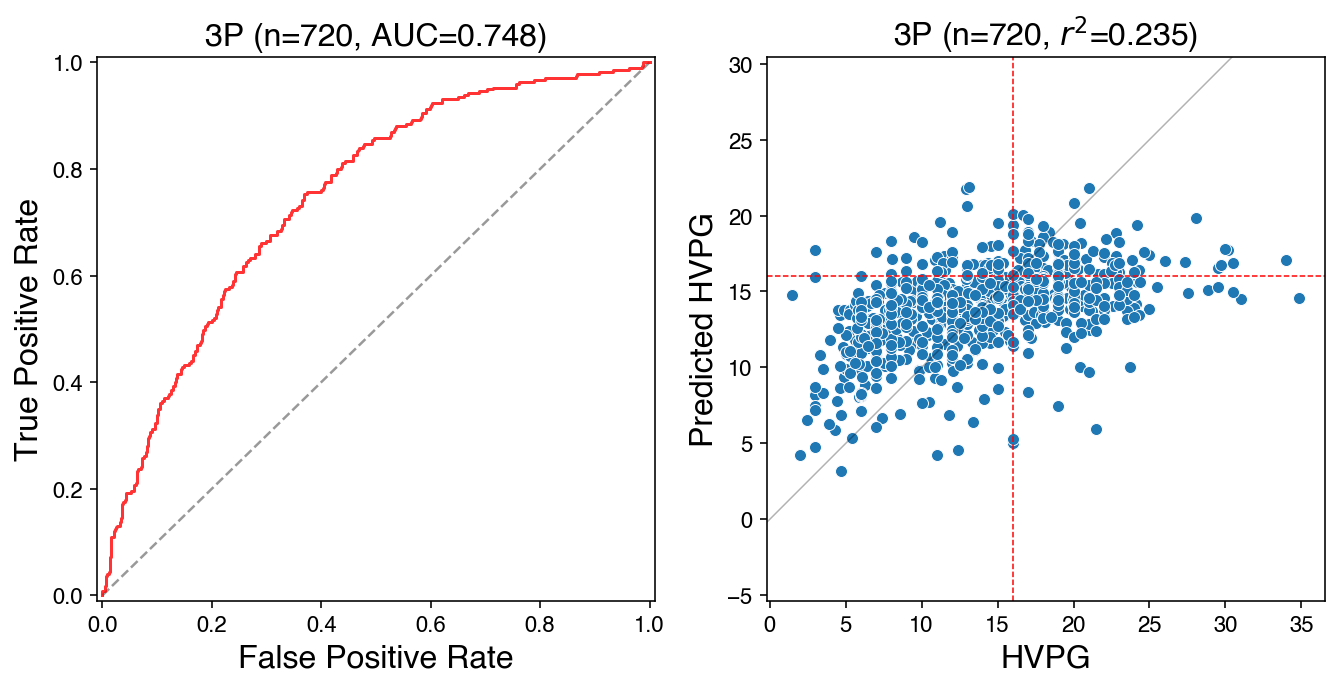

[PLT, BILI, aPTT]: 720 patients

AUROC (train and validate on same data): 0.748
Logistic regression coefficients: intercept=-1.705274, PLT=-0.012717, BILI=0.068710, aPTT=0.068350
Optimal threshold: 0.377

r2 score (train and validate on same data): 0.235
Regression coefficients: intercept=11.401290, PLT=-0.032463, BILI=0.431855, aPTT=0.159394


In [17]:
i = 1
_ = train_final_model(data, variables[i], names[i])
lrs.append(_[0])
aucs.append(_[1])
regs.append(_[2])
r2s.append(_[3])
best_thresholds.append(_[4])

#### 5-parameter including liver stiffness

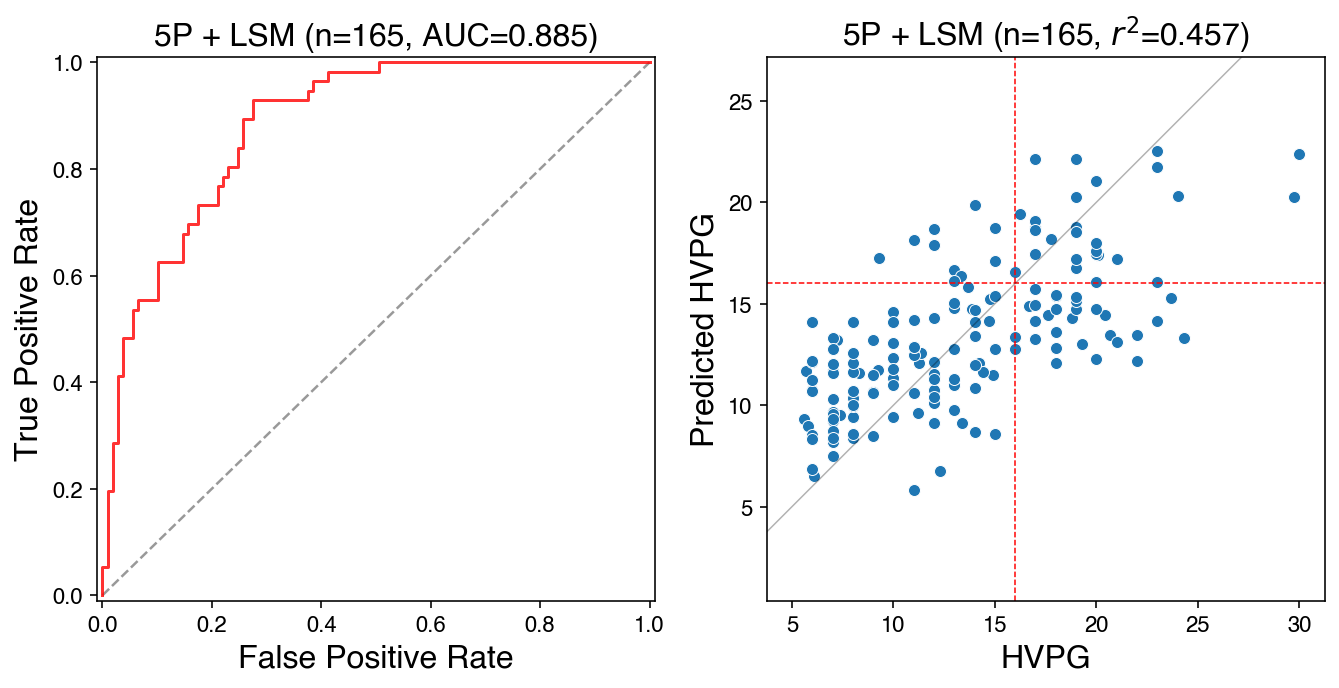

[PLT, BILI, aPTT, CHE, GGT, LSM]: 165 patients

AUROC (train and validate on same data): 0.885
Logistic regression coefficients: intercept=-4.614703, PLT=-0.018470, BILI=-0.084775, aPTT=0.162379, CHE=-0.336359, GGT=0.001778, LSM=0.044147
Optimal threshold: 0.231

r2 score (train and validate on same data): 0.457
Regression coefficients: intercept=6.707335, PLT=-0.017913, BILI=-0.057503, aPTT=0.211726, CHE=-0.530790, GGT=0.002686, LSM=0.119508


In [18]:
i = 2
_ = train_final_model(data, variables[i], names[i])
lrs.append(_[0])
aucs.append(_[1])
regs.append(_[2])
r2s.append(_[3])
best_thresholds.append(_[4])

#### 3-parameter including liver stiffness

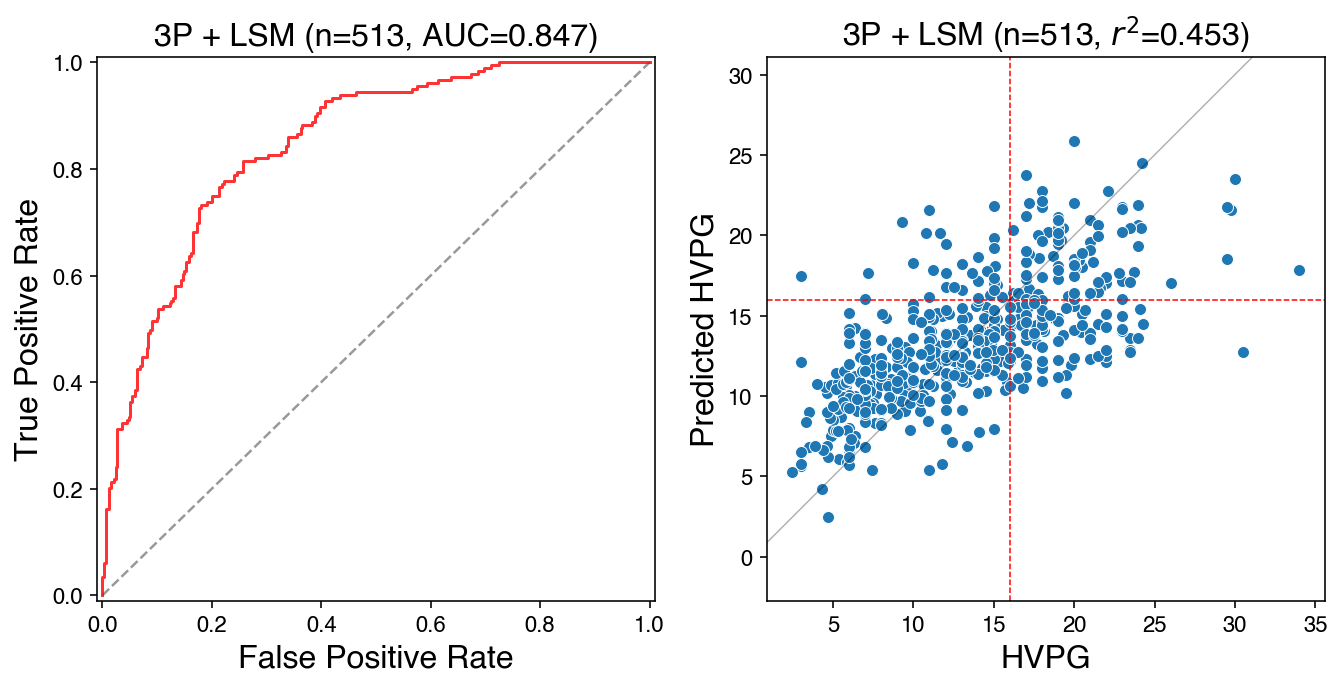

[PLT, BILI, aPTT, LSM]: 513 patients

AUROC (train and validate on same data): 0.847
Logistic regression coefficients: intercept=-3.396037, PLT=-0.013448, BILI=0.121784, aPTT=0.063862, LSM=0.060529
Optimal threshold: 0.312

r2 score (train and validate on same data): 0.453
Regression coefficients: intercept=7.888515, PLT=-0.025407, BILI=0.381041, aPTT=0.110612, LSM=0.150168


In [19]:
i = 3
_ = train_final_model(data, variables[i], names[i])
lrs.append(_[0])
aucs.append(_[1])
regs.append(_[2])
r2s.append(_[3])
best_thresholds.append(_[4])

#### Only liver stiffness

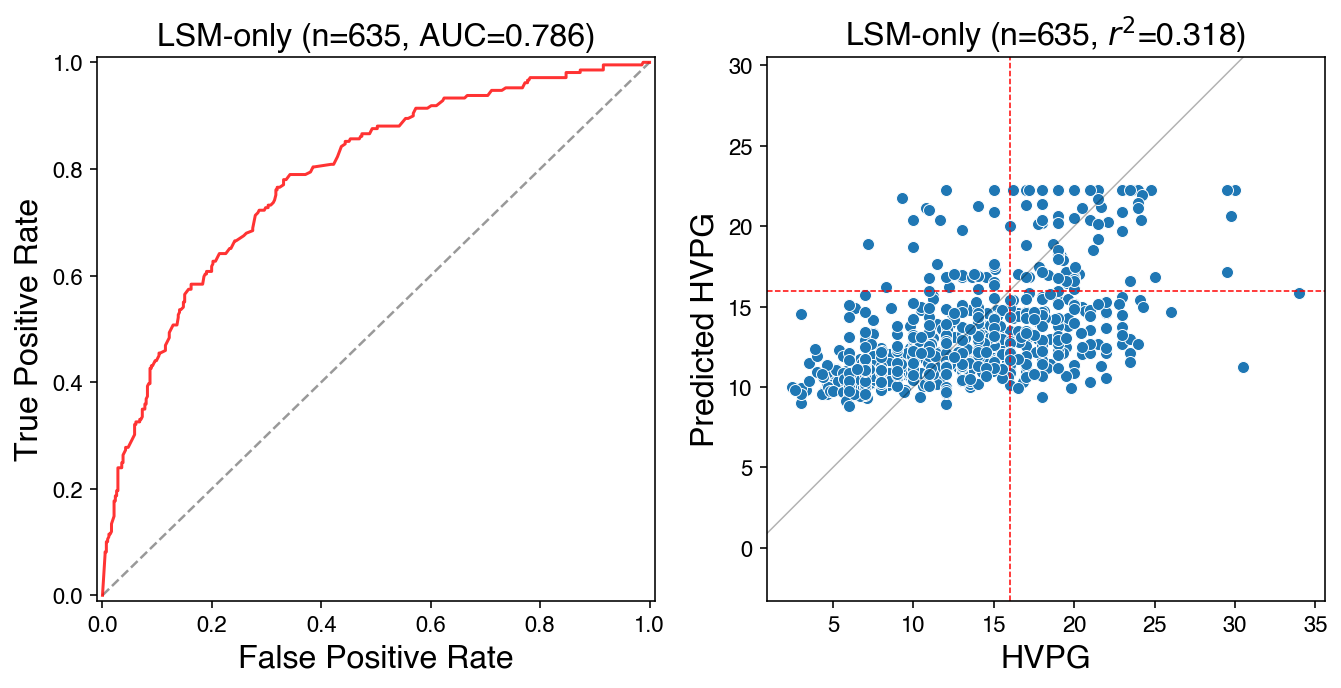

[LSM]: 635 patients

AUROC (train and validate on same data): 0.786
Logistic regression coefficients: intercept=-2.623919, LSM=0.067472
Optimal threshold: 0.256

r2 score (train and validate on same data): 0.318
Regression coefficients: intercept=8.163370, LSM=0.187643


In [20]:
i = 4
_ = train_final_model(data, variables[i], names[i])
lrs.append(_[0])
aucs.append(_[1])
regs.append(_[2])
r2s.append(_[3])
best_thresholds.append(_[4])

#### Report final metrics (on train cohort) in table

In [21]:
pd.DataFrame({"setting":names,"parameters":variables,"patients":n_patients,"AUC":aucs,"r2 score":r2s})

,setting,parameters,patients,AUC,r2 score
0,5P,"[PLT, BILI, aPTT, CHE, GGT]",209,0.828062,0.287215
1,3P,"[PLT, BILI, aPTT]",720,0.747873,0.234591
2,5P + LSM,"[PLT, BILI, aPTT, CHE, GGT, LSM]",165,0.884830,0.457131
3,3P + LSM,"[PLT, BILI, aPTT, LSM]",513,0.847272,0.452532
4,LSM-only,[LSM],635,0.785840,0.318449


### Save predictions of 3P+LSM model

In [22]:
def report_final_predictions(data, parameters, name, model):
    X = data[parameters].dropna(axis=0)
    # different behavior depending on if we deal with regression or classification model
    if str(type(model)) == r"<class 'sklearn.linear_model._ridge.Ridge'>":
        y = model.predict(X)
        X[name+"_HVPG_pred"] = y
    else:
        y = model.predict_proba(X)[:, 1]
        X[name+"_prob"] = y
    return X

In [23]:
data_preds = data.query('LSM.notna() & PLT.notna() & BILI.notna() & aPTT.notna() & HVPG.notna()').copy()
i = 3
data_preds = data_preds.merge(report_final_predictions(data, variables[i], names[i], lrs[i]).iloc[:,-1], how="left", left_index=True, right_index=True)
data_preds = data_preds.merge(report_final_predictions(data, variables[i], names[i], regs[i]).iloc[:,-1], how="left", left_index=True, right_index=True)

In [24]:
data_preds = data_preds[['dataset', 'Center-ID', 'LSM', 'PLT', 'BILI', 'aPTT', 'HVPG', '3P + LSM_HVPG_pred', '3P + LSM_prob']].sort_values("HVPG")
data_preds.to_csv(data_with_predictions_output_folder + "3P-LSM_predictions.csv")
data_preds[["HVPG", "3P + LSM_HVPG_pred", "3P + LSM_prob"]]

,HVPG,3P + LSM_HVPG_pred,3P + LSM_prob
330,2.450,5.306961,0.007610
164,3.000,6.533872,0.015073
156,3.000,5.796359,0.010384
415,3.000,17.482285,0.745851
24,3.000,12.105984,0.232272
...,...,...,...
871,29.500,21.764825,0.929158
470,29.739,21.585183,0.932416
832,30.000,23.533472,0.973612
957,30.500,12.713274,0.258300


### Addendum: save predictions (if available) for each model and add to original table - all 5 settings

In [25]:
data_preds = data.copy()
for i in range(len(names)):
    data_preds = data_preds.merge(report_final_predictions(data, variables[i], names[i], lrs[i]).iloc[:,-1], how="left", left_index=True, right_index=True)
    data_preds = data_preds.merge(report_final_predictions(data, variables[i], names[i], regs[i]).iloc[:,-1], how="left", left_index=True, right_index=True)

In [26]:
parameter_report  = ['dataset', 'Center-ID', 'HVPG', 'LSM', 'PLT', 'BILI', 'GGT', 'aPTT', 'CHE', 
                     '5P_prob', '5P_HVPG_pred', '3P_prob', '3P_HVPG_pred', '5P + LSM_prob', '5P + LSM_HVPG_pred', '3P + LSM_prob', '3P + LSM_HVPG_pred', 'LSM-only_prob', 'LSM-only_HVPG_pred']

In [27]:
data_preds = data_preds[parameter_report].sort_values("HVPG")
data_preds.to_csv(data_with_predictions_output_folder + "all_final_models_predictions.csv")